In [1]:
import argparse
import os
import sys
from PIL import Image, PngImagePlugin
import glob
import numpy as np
np.set_printoptions(threshold=25)
import scipy.fftpack
import pandas as pd
import time
import h5py
from collections import deque
from imgaug import augmenters as iaa
import imgaug as ia

In [3]:
#interlacing, compression, aspect ratio, kleur shift

https://github.com/aleju/imgaug

Add(V, PCH)	Adds value V to each image. If PCH is true, then the sampled values may be different per channel.

AdditiveGaussianNoise(L, S, PCH)	Adds white/gaussian noise pixelwise to an image. The noise comes from the normal distribution N(L,S). If PCH is true, then the sampled values may be different per channel (and pixel).

JpegCompression(C)	Applies JPEG compression of strength C (value range: 0 to 100) to an image. Higher values of C lead to more visual artifacts.

AddToHueAndSaturation(V, PCH, F, C)	Adds value V to each pixel in HSV space (i.e. modifying hue and saturation). Converts from colorspace F to HSV (default is F=RGB). Selects channels C before augmenting (default is C=[0,1]). If PCH is true, then the sampled values may be different per channel.

GammaContrast(G, PCH)	Applies gamma contrast adjustment following I_ij' = I_ij**G', where G' is a gamma value sampled from G and I_ij a pixel (converted to 0 to 1.0 space). If PCH is true, a different G' is sampled per image and channel.

PerspectiveTransform(S, KS)	Applies a random four-point perspective transform to the image (kinda like an advanced form of cropping). Each point has a random distance from the image corner, derived from a normal distribution with sigma S. If KS is set to True (default), each image will be resized back to its original size.

Resize(S, I)	Resizes images to size S. Common use case would be to use S={"height":H, "width":W} to resize all images to shape HxW. H and W may be floats (e.g. resize to 50% of original size). Either H or W may be "keep-aspect-ratio" to define only one side's new size and resize the other side correspondingly. I is the interpolation to use (default: cubic).

In [3]:
add1 = iaa.Sequential([iaa.Add(100, True)]) #-100: darker +100: lighter
# gauss = iaa.Sequential([iaa.AdditiveGaussianNoise(0, 20, True)]) #sigma determines maount of saltnpepper noise
# compress = iaa.Sequential([iaa.JpegCompression(96)]) #higher than 90
# add_hsv = iaa.Sequential(iaa.AddToHueAndSaturation(-15, True)) #-15 vs 15
# contrast = iaa.Sequential(iaa.GammaContrast(0.5, False)) #0.5 vs 2
# resize = iaa.Sequential(iaa.Resize({"height":0.8, "width":0.5})) 

# plot waardes vs metrics, gegeven de threshold die ik wil nemen
# om te kijken of de fotos dan waarschijnlijk zijn

In [4]:
def get_hash(frame, hash_size, high_freq_factor, input_type = 'path'):
    if input_type == 'path':
        im = Image.open(frame_path).convert("RGB") 
    elif input_type == 'pil':
        im = frame
    img_size = hash_size * high_freq_factor
    image = im.convert("L").resize((img_size, img_size), Image.ANTIALIAS)
    pixels = np.asarray(image)
    dct = scipy.fftpack.dct(scipy.fftpack.dct(pixels, axis=0), axis=1)
    dctlowfreq = dct[:hash_size, :hash_size]
    med = np.median(dctlowfreq)
    diff = dctlowfreq > med
    phash = [1 if x == True else 0 for x in diff.flatten()]
    return phash

In [5]:
def augment_test_image(frame_paths, n, method):
    test_image = Image.open(frame_paths[n]).convert("RGB") 
    im = np.asarray(test_image)
    im = np.expand_dims(im, axis=0)
    k, h, w, d = im.shape
    im = method.augment_images(im)
    im = im.reshape((im.shape[1], im.shape[2], im.shape[3]))
    test_image_aug = Image.fromarray(im)
    return test_image_aug

def augment_and_hash(frame_path, method, hash_size, high_freq_factor):
    im = Image.open(frame_path).convert("RGB") 
    im = np.asarray(im)
    im = np.expand_dims(im, axis=0)
    k, h, w, d = im.shape
    im = method.augment_images(im)
    im = im.reshape((im.shape[1], im.shape[2], im.shape[3]))
    im = Image.fromarray(im)
    phash = get_hash(im, hash_size, high_freq_factor, input_type = 'pil')
    return phash

In [ ]:
im = augment_test_image()

In [11]:
def load_dataset(dataset_name):
    
    def change_hash(dataset_column):
        phashes = list(dataset_column)
        new_phashes = []
        for phash in phashes:
            new_hash = np.array([int(e) for e in phash if e =='0' or e =='1'])
            new_phashes.append(new_hash)
        return new_phashes

#     loc = globals()['_dh'][0] 
#     dataset_name = loc + '/films/film_1/hashes/' + dataset_name
    with open(dataset_name) as csvfile:
        dataset = pd.read_csv(csvfile)
    
    columns = []
    for column in dataset.columns:
        if 'hash' in column:
            dataset[column] = change_hash(dataset[column])
    return dataset

def write_dataset(dataset, dataset_name):
#     loc = globals()['_dh'][0] 
#     dataset_name = loc + '/films/film_1/hashes/' + dataset_name
    dataset.to_csv(dataset_name)

In [13]:
im = augment_test_image(frame_paths, 839, add1)

In [16]:
im2 = augment_test_image(frame_paths, 840, add1)

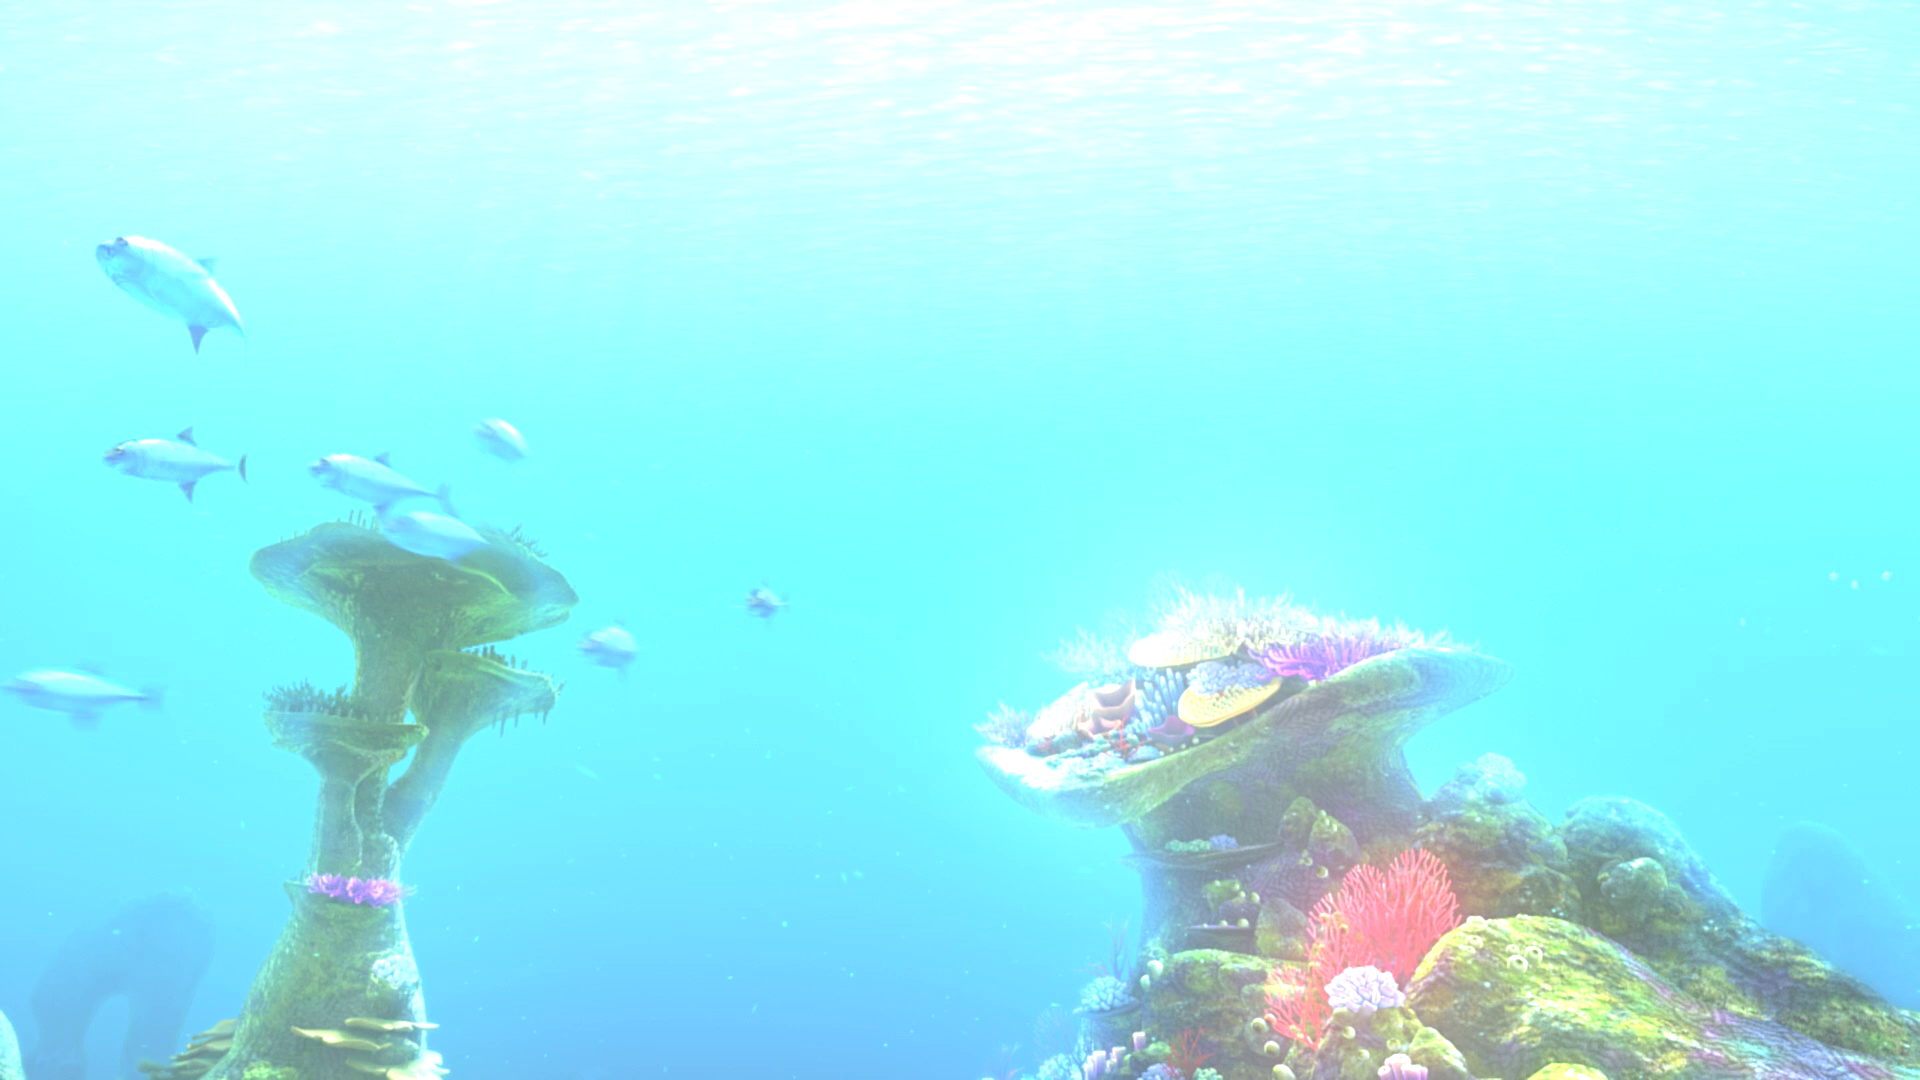

In [14]:
im

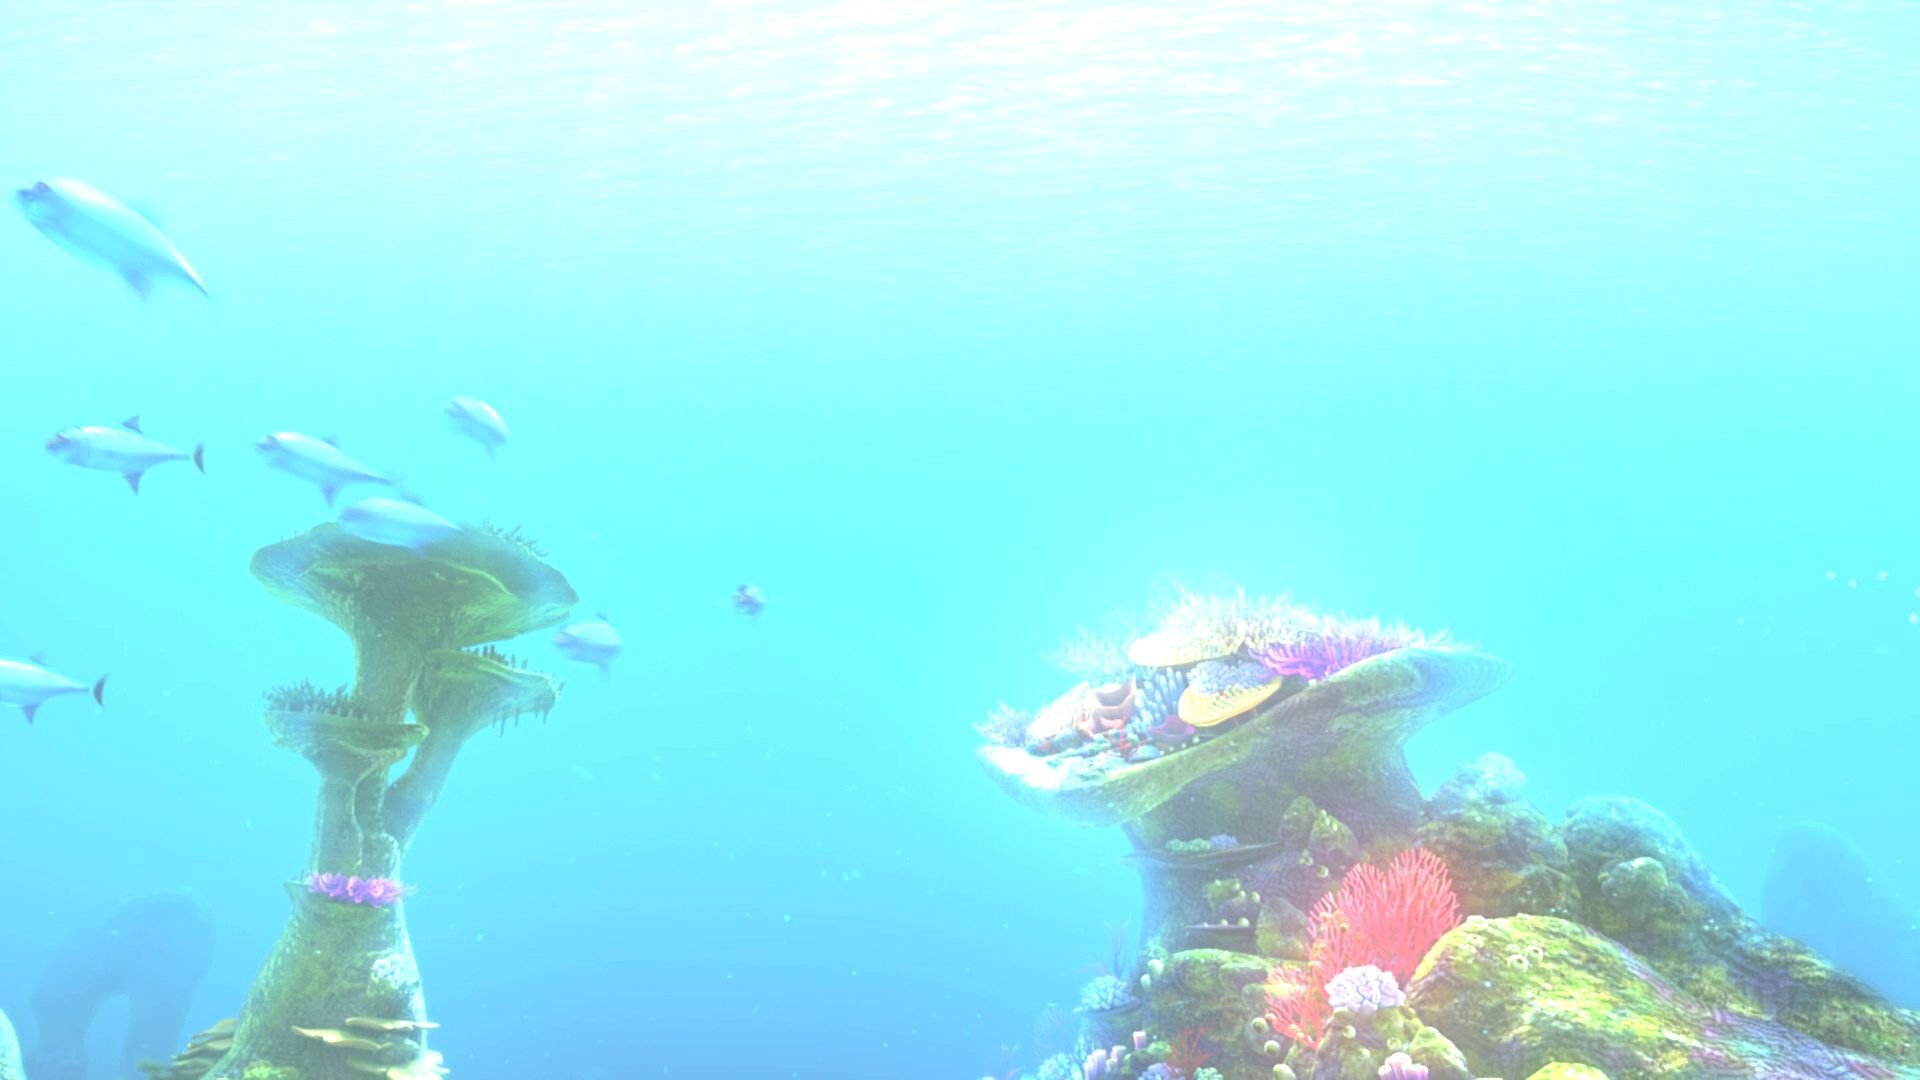

In [17]:
im2

In [6]:
hash_size = 15
high_freq_factor = 4

n_film = 1
wd_frames = os.getcwd() + '/films/film_{}/frames/'.format(n_film)
frame_paths = sorted(glob.glob(wd_frames + '*'))

wd_film = os.getcwd() + '/films/film_{}/film/'.format(n_film)
film_name = glob.glob(wd_film + '*')[0].split('/')[-1].replace(' ', '-')[0:7]
film_name = 'SeeFoo'
wd_hashes = os.getcwd() + '/films/film_{}/hashes/'.format(n_film)

dataset_name = wd_hashes + '{}-hashes-{}-{}.csv'.format(film_name, hash_size, high_freq_factor)

new_dataset_name = wd_hashes + '{}-hashes-{}-{}-augmented-2.csv'.format(film_name, hash_size, high_freq_factor)


In [25]:
dataset = load_dataset(dataset_name)

In [ ]:
add_params = [-100, -50, 50, 100]
gauss_params = [5, 10, 20, 30]
add_hsv_params = [-20, -10, 10, 20]
contrast_params = [0.1, 0.5, 1, 2]

for i in range(0, len(add_params)):
    add = iaa.Sequential([iaa.Add(add_params[i], True)]) #-100: darker +100: lighter
    gauss = iaa.Sequential([iaa.AdditiveGaussianNoise(0, gauss_params[i], True)]) #sigma determines maount of saltnpepper noise
    add_hsv = iaa.Sequential(iaa.AddToHueAndSaturation(add_hsv_params[i], True)) #-15 vs 15
    contrast = iaa.Sequential(iaa.GammaContrast(contrast_params[i], False)) #0.5 vs 2

    phashes_add = [augment_and_hash(frame_path, add, hash_size, high_freq_factor) for frame_path in frame_paths]
    phashes_gauss = [augment_and_hash(frame_path, gauss, hash_size, high_freq_factor) for frame_path in frame_paths]
    phashes_add_hsv = [augment_and_hash(frame_path, add_hsv, hash_size, high_freq_factor) for frame_path in frame_paths]
    phashes_contrast = [augment_and_hash(frame_path, contrast, hash_size, high_freq_factor) for frame_path in frame_paths]

    dataset['hash_add_{}'.format(i)] = phashes_add
    dataset['hash_gauss_{}'.format(i)] = phashes_gauss
    dataset['hash_add_hsv_{}'.format(i)] = phashes_add_hsv
    dataset['hash_contrast_{}'.format(i)] = phashes_contrast
    
    new_dataset_name_i = new_dataset_name.split('.')[0] + '-{}.'.format(i) + new_dataset_name.split('.')[1]
    new_dataset_name_i
    
    write_dataset(dataset, new_dataset_name)

In [13]:
phashes_add = [augment_and_hash(frame_path, add, hash_size, high_freq_factor) for frame_path in frame_paths]
phashes_gauss = [augment_and_hash(frame_path, gauss, hash_size, high_freq_factor) for frame_path in frame_paths]
phashes_compress = [augment_and_hash(frame_path, compress, hash_size, high_freq_factor) for frame_path in frame_paths]
phashes_add_hsv = [augment_and_hash(frame_path, add_hsv, hash_size, high_freq_factor) for frame_path in frame_paths]
phashes_contrast = [augment_and_hash(frame_path, contrast, hash_size, high_freq_factor) for frame_path in frame_paths]
phashes_resize = [augment_and_hash(frame_path, resize, hash_size, high_freq_factor) for frame_path in frame_paths]


In [14]:
dataset['hash_add'] = phashes_add
dataset['hash_gauss'] = phashes_gauss
dataset['hash_compress'] = phashes_compress
dataset['hash_add_hsv'] = phashes_add_hsv
dataset['hash_contrast'] = phashes_contrast
dataset['hash_resize'] = phashes_resize

In [17]:
write_dataset(dataset, new_dataset_name)


In [6]:
new_dataset_name

NameError: name 'new_dataset_name' is not defined

In [18]:
dataset = load_dataset(new_dataset_name)

In [19]:
dataset

,Unnamed: 0,film_name,frame,hash,annotation,hash_add,hash_gauss,hash_compress,hash_add_hsv,hash_contrast,hash_resize
0,0,Um-Méto,frame00000,"[0, 0, 0, 0, 0, 0]",1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,Um-Méto,frame00001,"[0, 0, 0, 0, 0, 0]",0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,Um-Méto,frame00002,"[0, 0, 0, 0, 0, 0]",1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,Um-Méto,frame00003,"[0, 0, 0, 0, 0, 0]",1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,Um-Méto,frame00004,"[0, 0, 0, 0, 0, 0]",1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,5,Um-Méto,frame00005,"[0, 0, 0, 0, 0, 0]",0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,6,Um-Méto,frame00006,"[0, 0, 0, 0, 0, 0]",1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,7,Um-Méto,frame00007,"[0, 0, 0, 0, 0, 0]",1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,8,Um-Méto,frame00008,"[0, 0, 0, 0, 0, 0]",1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,9,Um-Méto,frame00009,"[0, 0, 0, 0, 0, 0]",0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
im = augment_test_image(frame_paths, 2000, compress)